In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ab-testing/ab_data.csv


In [52]:
df = pd.read_csv('/kaggle/input/ab-testing/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [53]:
print("****** Descripting of data *********", "\n")
print("lenght of data: {}".format(df.shape))
#print(df.describe().T)
print(df.dtypes, "\n")

print("****** Description 2 of data *********", "\n")
for col in df.columns:
    if col != 'user_id':
        print("unique columns for {} is {}".format(col, len(df[col].unique())))
        if len(df[col].unique()) <= 2:
            print(df[col].value_counts(), "\n")


****** Descripting of data ********* 

lenght of data: (294478, 5)
user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object 

****** Description 2 of data ********* 

unique columns for timestamp is 294478
unique columns for group is 2
treatment    147276
control      147202
Name: group, dtype: int64 

unique columns for landing_page is 2
new_page    147239
old_page    147239
Name: landing_page, dtype: int64 

unique columns for converted is 2
0    259241
1     35237
Name: converted, dtype: int64 



## Step1: data cleaning

In [54]:
mask1 = (df["group"] == "control") & (df["landing_page"] == "new_page")
index_to_drop1 = df[mask1].index
df = df.drop(index_to_drop1)

mask1 = (df["group"] == "treatment") & (df["landing_page"] == "old_page")
index_to_drop1 = df[mask1].index
df = df.drop(index_to_drop1)

In [55]:
print(pd.crosstab(df['group'], df['converted']), '\n')
print(pd.crosstab(df['group'], df['landing_page']))

converted       0      1
group                   
control    127785  17489
treatment  128047  17264 

landing_page  new_page  old_page
group                           
control              0    145274
treatment       145311         0


In [56]:
# we want to make sure that the users are different: they dont apperar twice. if thats the case then we are going to remove them from our data

session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

# its a small number hence we are going ahead without deleting it
users_to_drop = session_counts[session_counts > 1].index
print(users_to_drop)

df = df[~df['user_id'].isin(users_to_drop)]

There are 1 users that appear multiple times in the dataset
Int64Index([773192], dtype='int64')


## Step2: Choosing the sampel size

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.

The sample size we need is estimated through something called Power analysis, and it depends on a few factors:
power, alpha and effect size

      power = 1-beta
This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 by convention,

power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

      alpha = 0.05
Alpha is the threshold we set. If the probability of observing a result as extreme or more (p-value) is lower than α, then we reject the Null hypothesis”. Since our α=0.05 (indicating 5% probability), our confidence (1 — α) is 95%.

    Null hupothesis: there is no change in the coversion rate (conversion rate of new and old design is same)

In [57]:

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
# in thsi example the project manager told us that the conversion rate before was 13% byt they want the conversion rate to be 15%
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

#print('effect_size', effect_size)

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


## Step 3: sampling

I’ve set random_state=22 so that the results are reproducible if you feel like following on your own Notebook: just use random_state=22 in your function and you should get the same sample as I did.


In [61]:
df_control = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
df_treatment = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

In [62]:
ab_test = pd.concat([df_control, df_treatment], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [64]:
print(pd.crosstab(ab_test['group'], ab_test['converted']), '\n')
print(pd.crosstab(ab_test['group'], ab_test['landing_page']))

converted     0    1
group               
control    4152  568
treatment  4147  573 

landing_page  new_page  old_page
group                           
control              0      4720
treatment         4720         0


In [66]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.s(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.005
treatment,0.121,0.327,0.005


from the above results, the conversion rate looks very similar, the treatment group performed slighly better

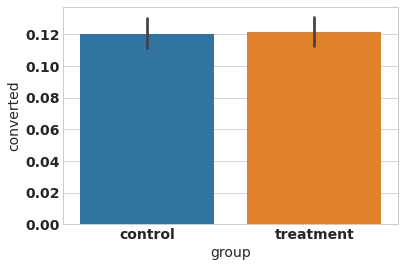

In [69]:
plt.figure()
sns.barplot(x=ab_test['group'], y=ab_test['converted'])

#### Now we want to see how statistically significant is this test. Hence we will perform hypothesis testing. We will calculate the p value. we can use the normal approximation for calculating our p-value 

In [72]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

4720
z statistic: -0.16
p-value: 0.875
ci 95% for control group: [0.111, 0.130]
ci 95% for treatment group: [0.112, 0.131]


the p value of 0.87isway above the threshold that we set 0.05. So, we can not reject our null hypothesis, that is the new design is better than the old one.

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board!

In [73]:
print(successes)
print(nobs)

[568, 573]